# Cotton Imaging Mask R-CNN Model

In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.9 ; cuda:  cu111


In [2]:
# Some basic setup:
# Setup detectron2 logger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

import fiftyone as fo
from PIL import Image

# Preparing Training and Testing Datasets

In [3]:
register_coco_instances("CottonImaging_train", {}, '/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/TrainingSet1_imbalanced_80.json', "/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/DataSet2_80")
metadata_train = MetadataCatalog.get("CottonImaging_train")

In [4]:
register_coco_instances("CottonImaging_test", {}, "/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/TestingSet1_imbalanced_20.json", "/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/DataSet1_20")
metadata_test = MetadataCatalog.get("CottonImaging_test")

In [5]:
metadata_train

namespace(name='CottonImaging_train',
          json_file='/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/TrainingSet1_imbalanced_80.json',
          image_root='/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/DataSet2_80',
          evaluator_type='coco')

In [6]:
dataset_dicts = DatasetCatalog.get("CottonImaging_train")

[02/05 15:27:12 d2.data.datasets.coco]: Loaded 143 images in COCO format from /home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/TrainingSet1_imbalanced_80.json


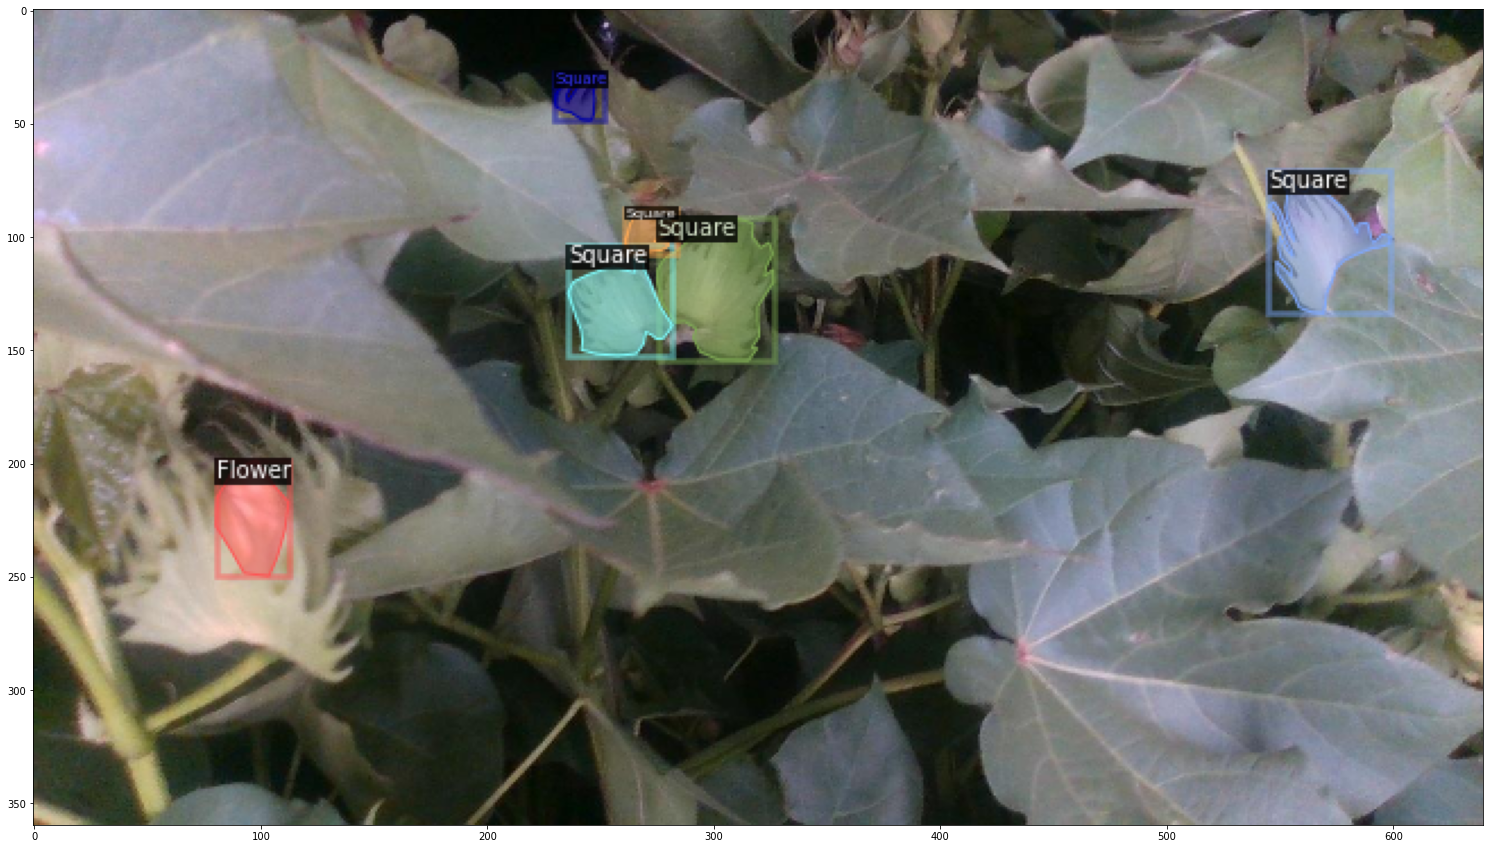

In [7]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_train, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

# Train Model

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("CottonImaging_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015  # Learning Rate
cfg.SOLVER.MAX_ITER = 2500    
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024   # Default = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  
cfg.OUTPUT_DIR = "/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20"
#os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
#trainer.train()

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
#%reload_ext tensorboard
!rm -rf ./logs/
%tensorboard --logdir logs/train_data

# Inference & evaluation using the trained model

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[Checkpointer] Loading from /home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/model_final.pth ...


In [134]:
# Create the dataset
#dataset.delete()

dataset = fo.Dataset.from_dir(
    data_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/DataSet2_80",
    labels_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/TrainingSet1_imbalanced_80.json",
    dataset_type=fo.types.COCODetectionDataset,
    label_types=["detections", "segmentations"],
    label_field = "ground_truth",
    #name="Model_2500_1024BatchSize_15LR"
)

#View summary info about the dataset
print(dataset)

 100% |█████████████████| 143/143 [3.0s elapsed, 0s remaining, 45.9 samples/s]      
Name:        2022.02.05.16.45.11
Media type:  image
Num samples: 143
Persistent:  False
Tags:        []
Sample fields:
    id:                         fiftyone.core.fields.ObjectIdField
    filepath:                   fiftyone.core.fields.StringField
    tags:                       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth_detections:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [135]:
# Print a ground truth detection
#dataset.persistent = True
sample = dataset.first()
print(sample.ground_truth_detections.detections[0])

<Detection: {
    'id': '61fefdf7667f07f48bb0d7d7',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'OpenBoll',
    'bounding_box': BaseList([
        0.43723464477780916,
        0.19509433962264147,
        0.06934616473252193,
        0.14163522012578625,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'Mature',
    'iscrowd': False,
    'sublabels': BaseList([]),
}>


In [136]:
print(sample.ground_truth_segmentations.detections[0].mask.shape)

(102, 88)


In [137]:
predictions_view = dataset.take(150, seed=51)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from PIL import Image

# Get class list
#classes = dataset.default_classes
classes = ["OpenBoll", "ClosedBoll", "Flower", "Square"]

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image = cv2.imread(sample.filepath)
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w , c = image.shape

        # Perform inference
        preds = predictor(image)
        labels = preds["instances"].pred_classes.cpu().detach().numpy()
        scores = preds["instances"].scores.cpu().detach().numpy()
        #boxes = preds["instances"].pred_boxes.tensor.cpu().detach().numpy()
        masks = preds["instances"].pred_masks.cpu().detach().numpy()
        
        # Convert detections to FiftyOne format
        detections = []
        segmentations = []
#        for label, score, box, seg in zip(labels, scores, boxes, masks):
        for label, score, seg in zip(labels, scores, masks):
        
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            #x1, y1, x2, y2 = box
            #rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

#             detections.append(
#                 fo.Detection.from_mask(
#                     mask=seg,
#                     label=classes[label],
#                     confidence=score
#                 )
#             )
            
            segmentations.append(
                fo.Detection.from_mask(
                    mask=seg,
                    label=classes[label],
                    confidence=score
                )
            )

        # Save predictions to dataset
#         sample["predictions"] = fo.Detections(detections=detections)
        sample["predictions"] = fo.Detections(detections=segmentations)
        sample.save()

print("Finished adding predictions")

 100% |█████████████████| 143/143 [12.9s elapsed, 0s remaining, 11.2 samples/s]      
Finished adding predictions



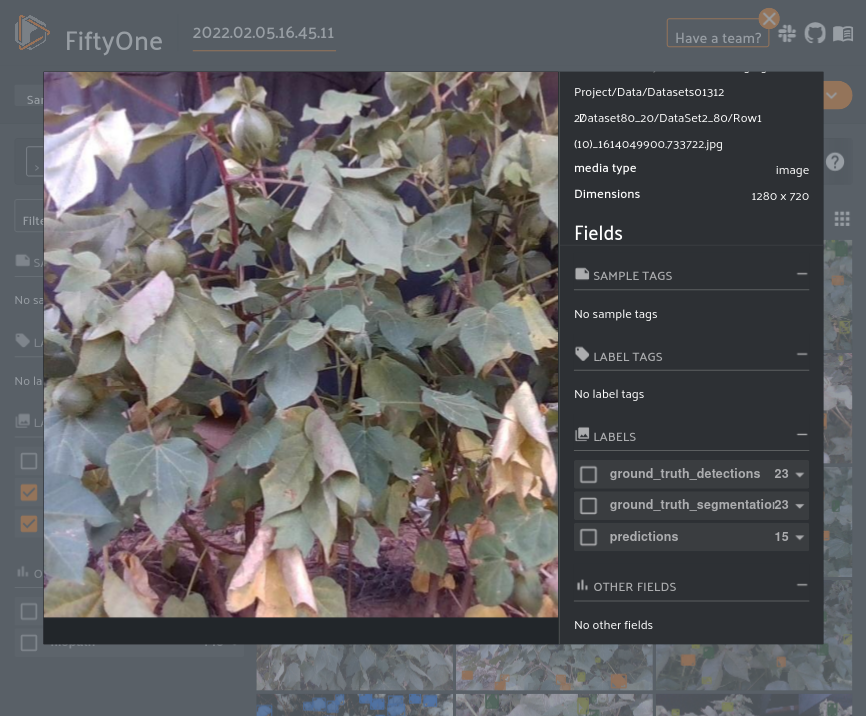

In [138]:
#session = fo.launch_app(dataset)
session.view = predictions_view

In [146]:
# Export the dataset GTdetections
dataset.export(
    labels_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/FiftyOne_Model_2500_1024BatchSize_15LR_GTdetection_training.json",
    dataset_type=fo.types.COCODetectionDataset,
    label_field = "ground_truth_detections",
)

 100% |█████████████████| 143/143 [1.5s elapsed, 0s remaining, 97.7 samples/s]         


In [140]:
# Export the dataset GTseg
dataset.export(
    labels_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/FiftyOne_Model_2500_1024BatchSize_15LR_GTsegmentation_training.json",
    dataset_type=fo.types.COCODetectionDataset,
    label_field = "ground_truth_segmentations",
)

   1% |/----------------|   2/143 [200.4ms elapsed, 14.1s remaining, 10.0 samples/s] 

/home/avl/.local/lib/python3.8/site-packages/fiftyone/utils/eta.py:946: UserWarning: Ignoring unsupported attribute type '<class 'mongoengine.base.datastructures.BaseList'>'
  warnings.warn(msg)


 100% |█████████████████| 143/143 [23.8s elapsed, 0s remaining, 3.7 samples/s]       


In [141]:
# Export the dataset predictions
dataset.export(
    labels_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/FiftyOne_Model_2500_1024BatchSize_15LR_predicitions_training.json",
    dataset_type=fo.types.COCODetectionDataset,
    label_field = "predictions",
)

 100% |█████████████████| 143/143 [20.4s elapsed, 0s remaining, 4.7 samples/s]      


In [153]:
import fiftyone.utils.coco as fouc

#dataset2.delete()

# Load GTdetections
exportedDataset = fo.Dataset.from_dir(
    data_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/DataSet2_80",
    labels_path="/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/FiftyOne_Model_2500_1024BatchSize_15LR_GTsegmentation_training.json",
    dataset_type=fo.types.COCODetectionDataset,    
    label_types="segmentations"
)

# And add GTsegs
# fouc.add_coco_labels(
#     exportedDataset,
#     "ground_truth",
#     "/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/FiftyOne_Model_2500_1024BatchSize_15LR_GTsegmentation_training.json",
#     label_type = "segmentations"
# )

# And add model predictions
fouc.add_coco_labels(
    exportedDataset,
    "predictions",
    "/home/avl/Projects/Cotton Imaging Project/Data/Datasets013122/Dataset80_20/FiftyOne_Model_2500_1024BatchSize_15LR_predicitions_training.json",
    label_type="segmentations"
)

#View summary info about the dataset
print(exportedDataset)

 100% |█████████████████| 143/143 [2.4s elapsed, 0s remaining, 62.2 samples/s]      
Name:        2022.02.05.16.57.57
Media type:  image
Num samples: 143
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [154]:
session = fo.launch_app(exportedDataset)

In [16]:
session.close()
#exportedDataset.delete()

In [132]:
classes = dataset.default_classes

print(classes)

['0', 'OpenBoll', 'ClosedBoll', 'Flower', 'Square']
